Provide your PDB ID and paste here a heatmap representing distances between beta-carbons (CB), consider alpha-carbons when the CB is missing, i.e. for glycine. Provide residue indexes along the axes.

In [1]:
from Bio.PDB import PDBList, is_aa, PDBIO, NeighborSearch
from Bio.PDB.PDBParser import PDBParser
from Bio.SeqUtils import IUPACData
from Bio.PDB.PDBIO import Select
from Bio.SeqIO.PdbIO import PdbSeqresIterator
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mplcolors
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

import numpy as np
import copy
import math

PDB_ID = "1jya"
PATH = "./pdb/"

In [2]:
pdbl = PDBList()
pdbl.retrieve_pdb_file(PDB_ID, pdir=PATH, file_format='pdb')

Structure exists: './pdb/pdb1jya.ent' 


'./pdb/pdb1jya.ent'

In [3]:
#Print PDB structure
parser = PDBParser(QUIET=True)
structure = parser.get_structure(PDB_ID, PATH + "/pdb{}.ent".format(PDB_ID))

class ChainSelect(Select):
    def accept_chain(self, chain):
        if chain.id == "A":
            return 1
        else:
            return 0
    def accept_residue(self, residue):
        if is_aa(residue):
            return 1
        else:
            return 0
    def accept_atom(self, atom):
        return 1
    
io = PDBIO()
io.set_structure(structure)
io.save("1jya_chainA.pdb", ChainSelect())


# Q1

Provide your PDB ID and paste here a heatmap representing distances between beta-carbons (CB), consider alpha-carbons when the CB is missing, i.e. for glycine. Provide residue indexes along the axes.

In [4]:
def get_distance_matrix(residues):
    # Get the distance matrix between CB atoms of residues, use CA if CB is not available
    distance_matrix = []
    for residue1 in residues:
        row = []
        for residue2 in residues:
            try:
                atom1 = residue1["CB"]
            except:
                atom1 = residue1["CA"]
            try:
                atom2 = residue2["CB"]
            except:
                atom2 = residue2["CA"]
            row.append(atom1 - atom2)
        distance_matrix.append(row)
    return np.array(distance_matrix)

In [5]:
# Open the PDB file 1jya_chainA.pdb and get the distance matrix
structure = parser.get_structure(PDB_ID, "1jya_chainA.pdb")
residues = list(structure.get_residues())
distance_matrix = get_distance_matrix(residues)
distance_matrix


array([[ 0.       ,  5.745207 ,  7.7545476, ..., 28.416048 , 29.579292 ,
        33.480484 ],
       [ 5.745207 ,  0.       ,  5.318993 , ..., 31.776705 , 32.05452  ,
        36.2932   ],
       [ 7.7545476,  5.318993 ,  0.       , ..., 27.866823 , 27.543842 ,
        32.00235  ],
       ...,
       [28.416048 , 31.776705 , 27.866823 , ...,  0.       ,  5.5380554,
         6.480599 ],
       [29.579292 , 32.05452  , 27.543842 , ...,  5.5380554,  0.       ,
         5.650439 ],
       [33.480484 , 36.2932   , 32.00235  , ...,  6.480599 ,  5.650439 ,
         0.       ]], dtype=float32)

# HEATMAP

/tmp/ipykernel_7737/2040413419.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  current_cmap = copy.copy(matplotlib.cm.get_cmap())


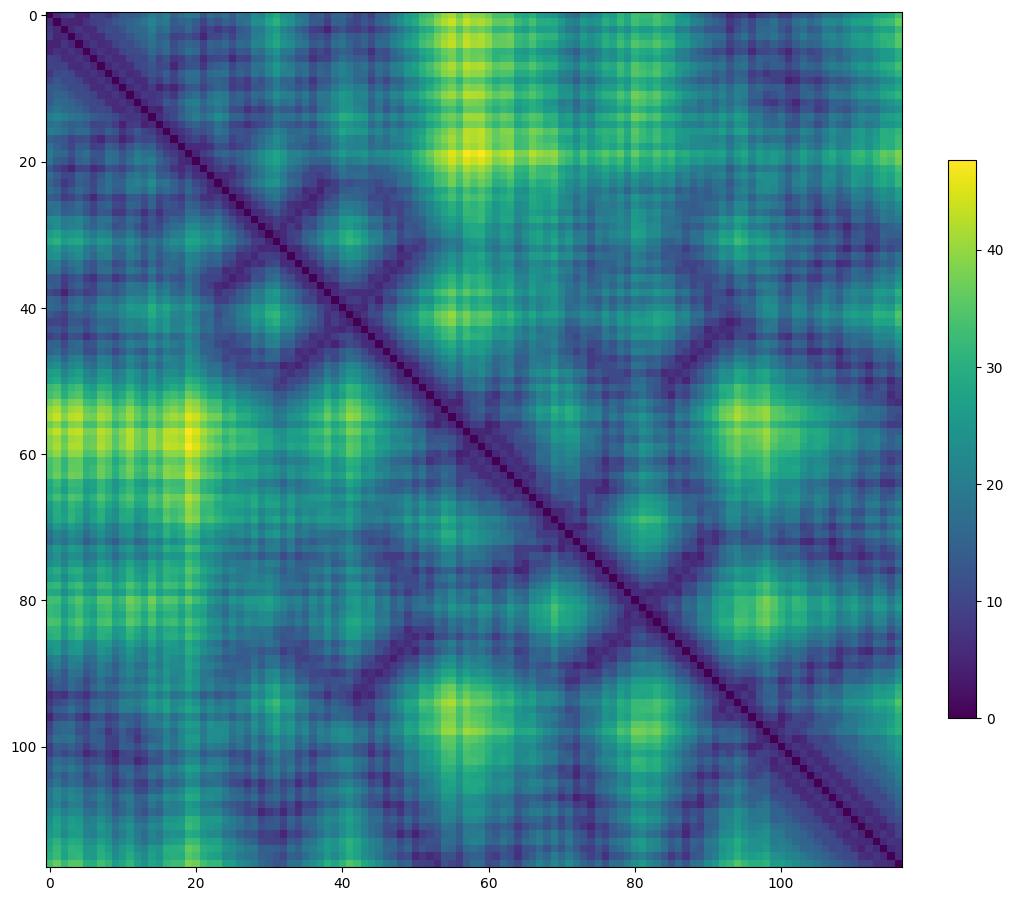

In [6]:
current_cmap = copy.copy(matplotlib.cm.get_cmap())
current_cmap.set_bad(color='white')

fig, ax = plt.subplots(figsize=(12, 12))
im = ax.imshow(distance_matrix)
fig.colorbar(im, fraction=0.03, pad=0.05)
plt.savefig(PATH + '/ca_distances_{}.png'.format(PDB_ID), dpi=300, bbox_inches='tight')

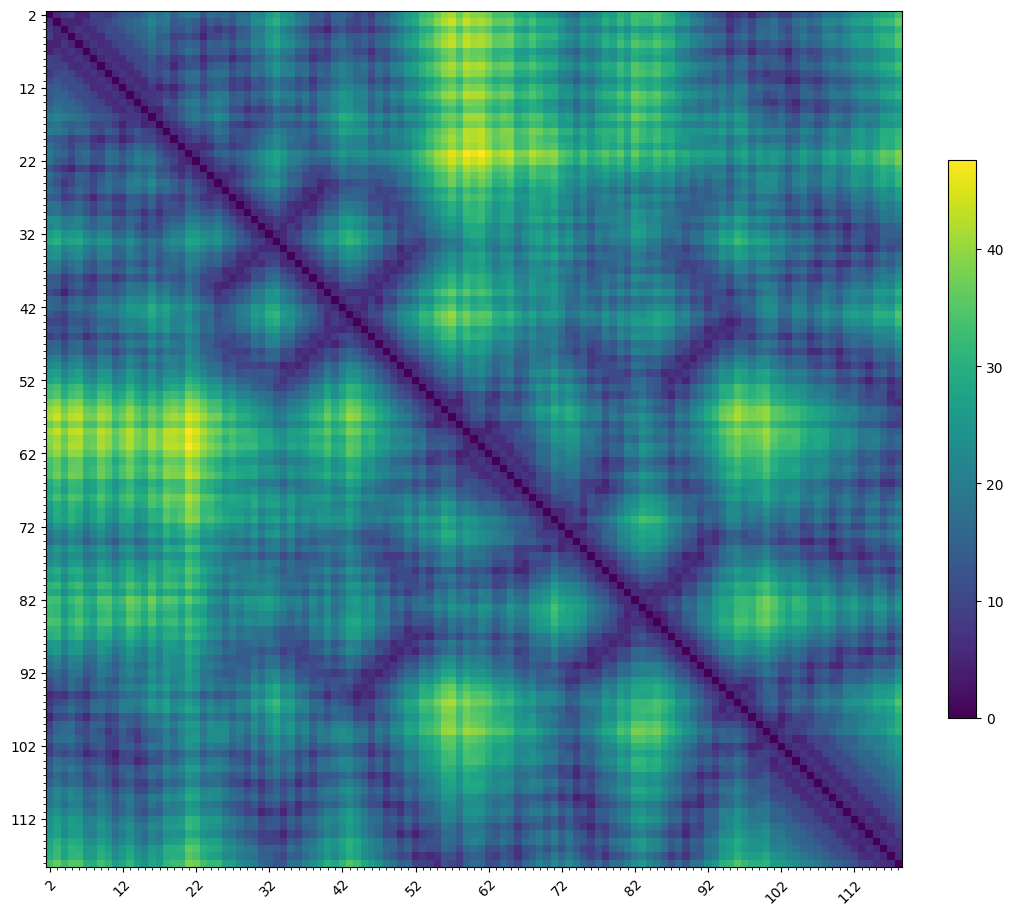

In [26]:
#Provide residue indexes along the axes.

fig, ax = plt.subplots(figsize=(12, 12))
im = ax.imshow(distance_matrix)
ax.set_xticks(np.arange(len(residues)))
ax.set_yticks(np.arange(len(residues)))
ax.set_xticklabels([residue.id[1] for residue in residues])
ax.set_yticklabels([residue.id[1] for residue in residues])
# Make ticks more spaced out
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_major_locator(MultipleLocator(10))
# Add minor ticks
ax.xaxis.set_minor_locator(AutoMinorLocator(10))
ax.yaxis.set_minor_locator(AutoMinorLocator(10))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
fig.colorbar(im, fraction=0.03, pad=0.05)

plt.savefig(PATH + '/ca_distances_{}.png'.format(PDB_ID), dpi=300, bbox_inches='tight')


# Contact Map
Paste the plot of the contacts map derived from the matrix above considering a distance threshold of 5 Å.

In [7]:
contact_map = (distance_matrix[:] < 5).astype(float)
contact_map 

# Count the number of contacts
num_contacts = np.sum(contact_map)
num_contacts

215.0

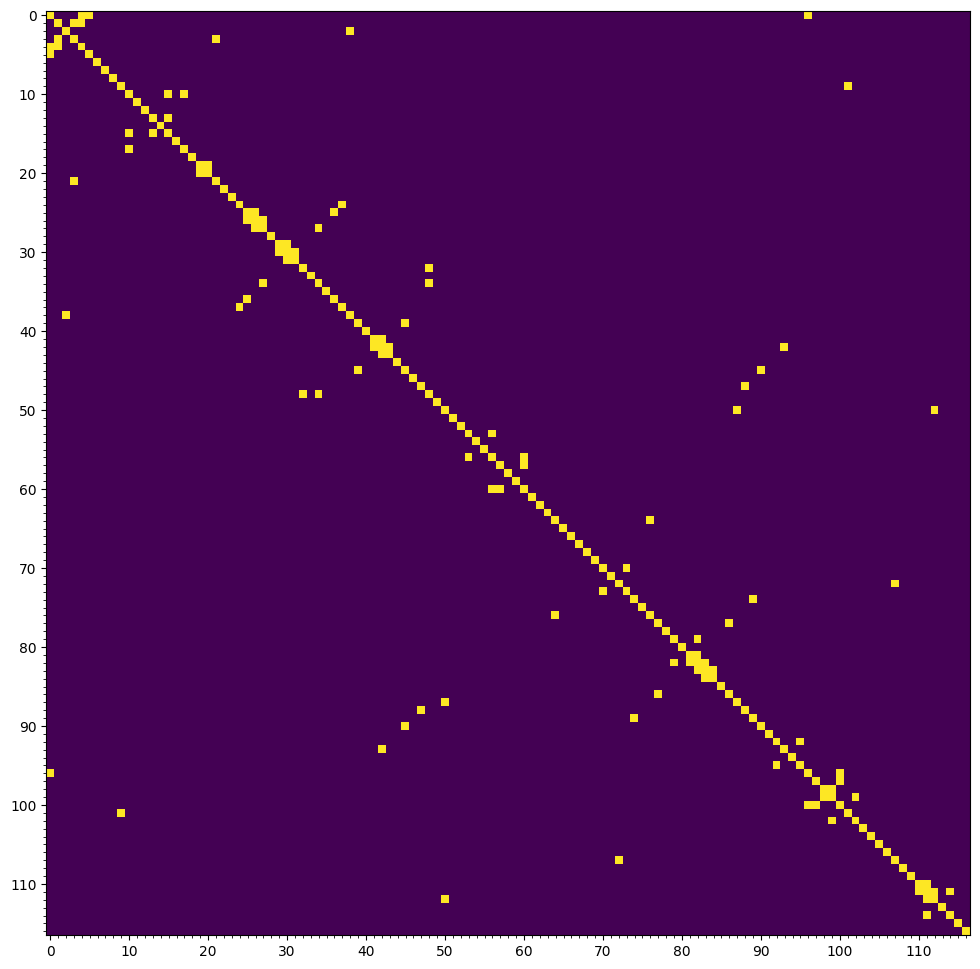

In [8]:
# Plot contact map
fig, ax = plt.subplots(figsize=(12, 12))
im = ax.imshow(contact_map)

# Set ticks
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(AutoMinorLocator(10))
ax.yaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(AutoMinorLocator(10))

plt.savefig(PATH + '/ca_contacts_{}.png'.format(PDB_ID), dpi=300, bbox_inches='tight')

In [9]:

# Calculate contacts
ns = NeighborSearch([atom for residue in residues for atom in residue.get_atoms()])

# Init a empty matrix
contact_map_nb = np.zeros((len(residues), len(residues)))

# "search_all" returns the list of atoms in contact based on a distance cutoff
# level="R" returns pairs of residues instead of atoms
for residue1, residue2 in ns.search_all(3.5, level="R"):
  # Sequence separation >= 6
  if abs(residue1.id[1] - residue2.id[1]) >= 6:
    contact_map_nb[residues.index(residue1), residues.index(residue2)] = 1
    # Add also the other part of the matrix
    contact_map_nb[residues.index(residue2), residues.index(residue1)] = 1
contact_map_nb

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

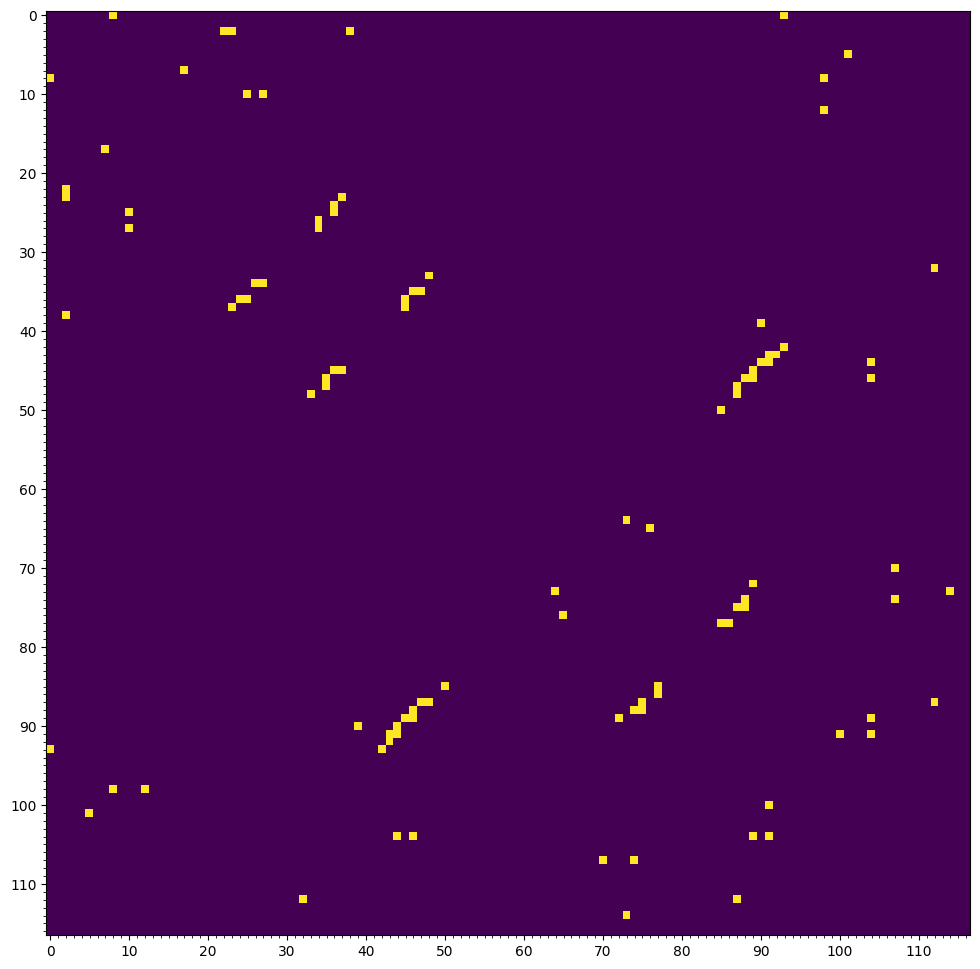

In [10]:
# Plot contact map
fig, ax = plt.subplots(figsize=(12, 12))
im = ax.imshow(contact_map_nb)

# Set ticks
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(AutoMinorLocator(10))
ax.yaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(AutoMinorLocator(10))

plt.savefig(PATH + '/all_contacts_{}.png'.format(PDB_ID), dpi=300, bbox_inches='tight')

# Q3

Report the number of residues in contacts for different ranges of sequence separation. Consider the following intervals [0,6], [7,12] and [13,24] and [25,∞]. 

In [11]:
def get_distance_matrix(residues, min_seq_sep=6, max_seq_sep=20):
    # Get the distance matrix between CB atoms of residues, use CA if CB is not available
    distance_matrix = []
    for residue1 in residues:
        row = []
        for residue2 in residues:
            dist = abs(residue1.id[1] - residue2.id[1])
            if min_seq_sep <= dist <= max_seq_sep:
                try:
                    atom1 = residue1["CB"]
                except:
                    atom1 = residue1["CA"]
                try:
                    atom2 = residue2["CB"]
                except:
                    atom2 = residue2["CA"]
                row.append(atom1 - atom2)
            else:
                row.append(np.nan)
        distance_matrix.append(row)
    return np.array(distance_matrix)

In [12]:
dist_zero_sei = get_distance_matrix(residues, 0, 6)
contact_map_zero_sei = (dist_zero_sei[:] < 5).astype(float)
contact_map_zero_sei
dist_sette_dodici = get_distance_matrix(residues, 7, 12)
contact_map_sette_dodici = (dist_sette_dodici[:] < 5).astype(float)
contact_map_sette_dodici
dist_tredici_ventiquattro = get_distance_matrix(residues, 13, 24)
contact_map_tredici_ventiquattro = (dist_tredici_ventiquattro[:] < 5).astype(float)
contact_map_tredici_ventiquattro
dist_vemtoquattro = get_distance_matrix(residues, 25, 999)
contact_map_ventiquattro = (dist_vemtoquattro[:] < 5).astype(float)
contact_map_ventiquattro

# Count the number of contacts
num_contacts_zero_sei = np.sum(contact_map_zero_sei)
num_contacts_sette_dodici = np.sum(contact_map_sette_dodici)
num_contacts_tredici_ventiquattro = np.sum(contact_map_tredici_ventiquattro)
num_contacts_ventiquattro = np.sum(contact_map_ventiquattro)

print("Number of contacts (0-6):", num_contacts_zero_sei)
print("Number of contacts (7-12):", num_contacts_sette_dodici)
print("Number of contacts (13-24):", num_contacts_tredici_ventiquattro)
print("Number of contacts (>=25):", num_contacts_ventiquattro)

print("Total number of contacts:", num_contacts_zero_sei + num_contacts_sette_dodici + num_contacts_tredici_ventiquattro + num_contacts_ventiquattro)

Number of contacts (0-6): 177.0
Number of contacts (7-12): 10.0
Number of contacts (13-24): 10.0
Number of contacts (>=25): 18.0
Total number of contacts: 215.0


# Q4

Generate and paste the Ramachandran plot of your protein.


In [13]:
from Bio.PDB import PDBList, calc_angle, calc_dihedral, PPBuilder, is_aa

In [14]:
print(structure)

<Structure id=1jya>


In [15]:
# Build the peptides (reveal structure holes) and print sequences
print("Peptides:")
ppb = PPBuilder()
for model in structure:
    for chain in model:
        print(chain.id, len([residue for residue in chain if is_aa(residue)]))
        for pp in ppb.build_peptides(chain):
            print(len(pp), pp.get_sequence())

Peptides:
A 117
46 YSFEQAITQLFQQLSLSIPDTIEPVIGVKVGEFACHITEHPVGQIL
60 FTLPSLDNNDEKETLLSHNIFSQDILKPILSWDEVGGHPVLWNRQPLNSLDNNSLYTQLE
9 LVQGAERLQ


In [16]:
# Calculate PSI and PHI
rama = {}  # { chain : [[residue_1, ...], [phi_residue_1, ...], [psi_residue_2, ...] ] }
for model in structure:
    for chain in model:
        for pp in ppb.build_peptides(chain):

            phi_psi = pp.get_phi_psi_list()  # [(phi_residue_1, psi_residue_1), ...]
            for i, residue in enumerate(pp):
               # print(model, chain, i, residue, phi_psi[i])

                # Convert radians to degrees and remove first and last value that are None
                if phi_psi[i][0] is not None and phi_psi[i][1] is not None:
                    rama.setdefault(chain.id, [[], [], []])
                    rama[chain.id][0].append(residue)
                    rama[chain.id][1].append(math.degrees(phi_psi[i][0]))
                    rama[chain.id][2].append(math.degrees(phi_psi[i][1]))


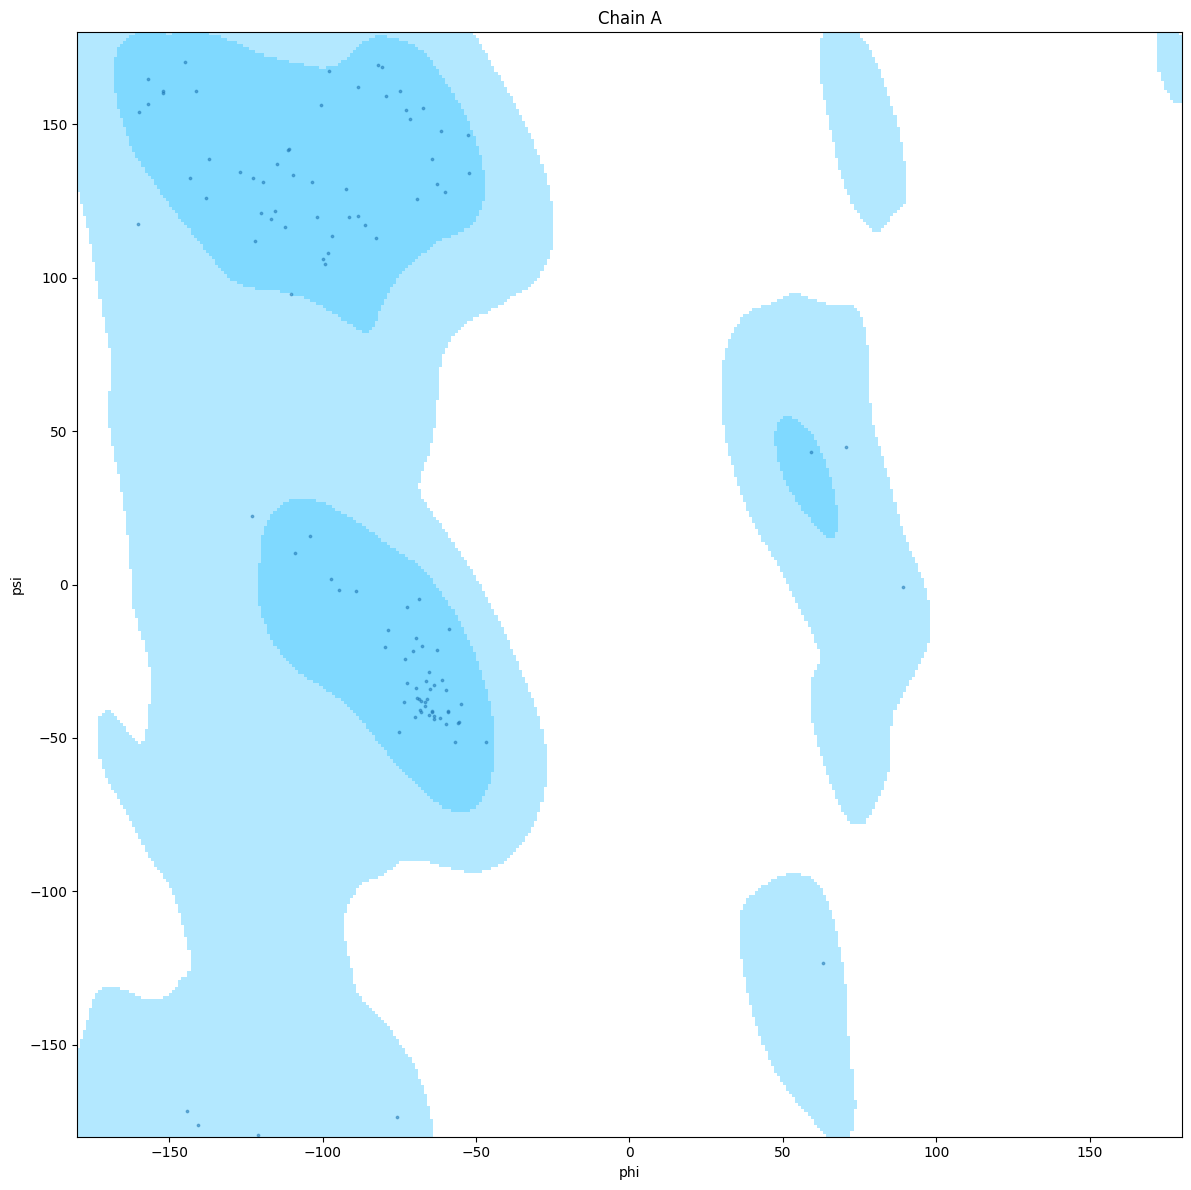

In [17]:
# Ramachandran regions
# 2 = 90%, 1 = 60%
regions_matrix = []
with open(PATH + "/ramachandran.dat") as f:
    for line in f:
        if line:
            regions_matrix.append([int(ele) for ele in line.strip().split()])

# Plot Ramachandran regions
cmap = mplcolors.ListedColormap(['#FFFFFF', '#B3E8FF', '#7FD9FF'])

f, axes = plt.subplots(1, len(rama), figsize=(12, 12))
axes = np.array(axes).reshape(-1)  # Hack to give consistency for single/multiple suplots (-1 force reshape to infer dimensions)
for ax, chain_id in zip(axes, rama):

    # Plot regions (60 percentile & 90 percentile)
    im = ax.imshow(regions_matrix, cmap=cmap, extent=(-180, 180, -180, 180))

    # Plot points
    ax.scatter(rama[chain_id][1], rama[chain_id][2], s=3, alpha=0.5)

    ax.set_xlabel('phi')
    ax.set_ylabel('psi')
    ax.set_title('Chain {}'.format(chain_id))

plt.tight_layout()  # Remove figure padding
plt.savefig(PATH +'/ramachandran_regions.png', dpi=300, bbox_inches='tight')

In [18]:
#Provide the number of residues which are Ramachandran outliers. 
#Hints: to identify outliers consider the Ramachandran regions as shown during the practicals.

# Count outliers

# 2 = 90%, 1 = 60%
outliers = 0
for chain_id in rama:
    for phi, psi in zip(rama[chain_id][1], rama[chain_id][2]):
        if regions_matrix[int(psi) + 180][int(phi) + 180] == 2:
            outliers += 1
outliers


10